In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataFields import DataFields, DropNAList, DateReportedFields
from ProjectFunctions import get_columns_from_chunk, convert_date_to_binary, drop_rows_with_na_greater_than
from ProjectFunctions import map_education_levels, map_vascular_levels
from typing import Callable, Any

UKBB_PATH = "~/biobank/ukb672220.csv"

VD_COL = "Vascular Dementia Report Date"

# A dictionary containing the used features
datafields = DataFields

# Features of conditions specified by date
datereportedfields = DateReportedFields

#### Measure the distribution of age

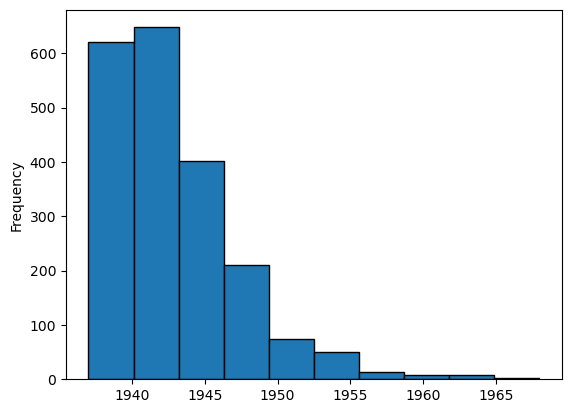

In [2]:
df = pd.read_csv("diagnosed_processed.csv")

# plot histogram of the birth year
df["Birth Year"].plot(kind='hist', bins=10, edgecolor='black')
birth_year_counts_histogram, birth_year_histogram_edges = np.histogram(df["Birth Year"], bins=10)
birth_year_histogram_edges = np.floor(birth_year_histogram_edges).astype(int)

#### Extract samples of patients undiagnosed with vascular dementia with similar birth year

##### Define features to drop if na

In [ ]:
drop_if_na_list = [
    "Birth Year",
    "Sex",
    "Education",
    "Smoking Status",
    "Ever Smoked",
    "Alcohol Intake Frequency",
    "Diabetes Diagnosed By Doctor",
    "Report of vascular problems",
    
# Blood Chem
    "Alanine aminotransferase",
    "Albumin",
    "Alkaline phosphatase",
    "Apolipoprotein A",
    "Apolipoprotein B",
    "Aspartate aminotransferase",
    "C-reactive protein",
    "Calcium",
    "Cholesterol",
    "Creatinine",
    "Cystatin C",
    "Direct bilirubin",
    "Gamma glutamyltransferase",
    "Glucose",
    "Glycated haemoglobin (HbA1c)",
    "HDL cholesterol",
    "IGF-1",
    "LDL direct",
    "Lipoprotein A",
    "Phosphate",
    "SHBG",
    "Testosterone",
    "Total bilirubin",
    "Total protein",
    "Triglycerides",
    "Urate",
    "Urea",
    "Vitamin D",
    
# Blood Count
    "Basophil count",
    "Basophil percentage",
    "Eosinophil count",
    "Eosinophil percentage",
    "Haematocrit percentage",
    "Haemoglobin concentration",
    "High light scatter reticulocyte count",
    "High light scatter reticulocyte percentage",
    "Immature reticulocyte fraction",
    "Lymphocyte count",
    "Lymphocyte percentage",
    "Mean corpuscular haemoglobin",
    "Mean corpuscular haemoglobin concentration",
    "Mean corpuscular volume",
    "Mean platelet (thrombocyte) volume",
    "Mean reticulocyte volume",
    "Mean sphered cell volume",
    "Monocyte count",
    "Monocyte percentage",
    "Neutrophil count",
    "Neutrophil percentage",
    "Nucleated red blood cell count",
    "Nucleated red blood cell percentage",
    "Platelet count",
    "Platelet crit",
    "Platelet distribution width",
    "Red blood cell (erythrocyte) count",
    "Red blood cell (erythrocyte) distribution width",
    "Reticulocyte count",
    "Reticulocyte percentage",
    "White blood cell (leukocyte) count",

# Blood Presure
    "Blood Pressure Diastolic",
    "Blood Pressure Systolic",
    "Pulse Rate at Blood Pressure"
]

##### Do this

In [3]:
def filter_chunk(chunk, column, condition):
    # remove unnecessary columns first.
    chunk = get_columns_from_chunk(chunk, datafields, oldest=True)

    chunk = map_education_levels(chunk)
    
    chunk["Report of vascular problems"] = chunk["Report of vascular problems"].replace({-7: 0, -3: pd.NA})

    # take only patients undiagnosed with vascular dementia
    chunk = chunk[chunk[VD_COL].isna()]
    
    # filter by condition function
    mask = condition(chunk[column])
    filtered_chunk = chunk.loc[mask]
    
    # convert items with value less than 0 to NA
    filtered_chunk = filtered_chunk.mask(filtered_chunk.select_dtypes(include='number') < 0)
    
    # drop all NA
    #filtered_chunk = filtered_chunk.dropna(subset=DropNAList) # drop if missing value for some columns
    filtered_chunk = drop_rows_with_na_greater_than(filtered_chunk, x=40, include=DropNAList)
    
    return filtered_chunk


In [4]:
# Sample "count" rows from dataframe following a condtion by chunks randomly.
def sample_by_condition(file_path, column, condition, count, samples_per_chunk, chunksize=10000):
    result = pd.DataFrame()
    samples_collected = 0
    
    for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):
            
        filtered_chunk = filter_chunk(chunk, column, condition)
        
        if filtered_chunk.empty:
            continue
        
        remaining_samples = count - samples_collected
        if remaining_samples <= 0:
            break
            
        # choose randomly if too many were collected
        k = min(samples_per_chunk, len(filtered_chunk))
        chunk_sample = filtered_chunk.sample(n=k)
    
        if result.empty:
            result = chunk_sample
        else:
            result = pd.concat([result, chunk_sample], ignore_index=True, copy=False)

        samples_collected += len(chunk_sample)

        if samples_collected >= count:
            break
            
    if samples_collected > count:
        return result.sample(n=count)
    else:
        return result

In [5]:
per_chunk = 100 # maximum samples to take from a single chunk per histogram column
col_name = "Birth Year" # The column to use as a rule for "sample_by_condition"

const = 20 # constant addition per histogram

undiagnosed_df = pd.DataFrame()

for i in range(len(birth_year_counts_histogram)):
    start, end = int(birth_year_histogram_edges[i]), int(birth_year_histogram_edges[i+1])
    count = birth_year_counts_histogram[i]
    
    df = sample_by_condition(UKBB_PATH,
                             col_name,
                             lambda x:(x >= start) & (x < end),
                             count + const,
                             per_chunk,
                            )
    print(f"{i+1} / {len(birth_year_counts_histogram)}: range {start} - {end}, gathered {len(df)}/{count+const}")
    
    undiagnosed_df = pd.concat([undiagnosed_df, df], ignore_index=True)

# assign undiagnosed
#undiagnosed_df["Vascular Dementia Report Date"] = pd.NA

# drop id column
undiagnosed_df = undiagnosed_df.drop(columns=["id"])

1 / 10: range 1937 - 1940, gathered 641/641
2 / 10: range 1940 - 1943, gathered 668/668
3 / 10: range 1943 - 1946, gathered 421/421
4 / 10: range 1946 - 1949, gathered 231/231
5 / 10: range 1949 - 1952, gathered 94/94
6 / 10: range 1952 - 1955, gathered 71/71
7 / 10: range 1955 - 1958, gathered 33/33
8 / 10: range 1958 - 1961, gathered 27/27
9 / 10: range 1961 - 1964, gathered 27/27
10 / 10: range 1964 - 1968, gathered 23/23


#### Save the CSV, and analyse the extracted data

Stroke Report Date: 2236 NA rows
Other Arthritis: 2236 NA rows
Juvenile Arthritis: 2236 NA rows
Other Rheumatoid Arthritis: 2236 NA rows
Seropositive Rheumatoid Arthritis: 2236 NA rows
Report of vascular problems: 2236 NA rows
Multiple Sclerosis: 2236 NA rows
Psoriatic and enteropathic arthropathies: 2236 NA rows
Crohn's disease: 2236 NA rows
B12 deficiency anaemia: 2236 NA rows
Myasthenia gravis: 2236 NA rows
Sjogren Disease (M35): 2236 NA rows
Thyrotoxicosis (Grave's disease): 2236 NA rows
Ulcerative Colitis: 2236 NA rows
Vascular Dementia Report Date: 2236 NA rows
Education: 2236 NA rows
Primary Hypertension: 2236 NA rows
Secondary Hypertension: 2236 NA rows
Diagnosed with Coeliac disease: 1620 NA rows
Lipoprotein A: 533 NA rows
Direct bilirubin: 385 NA rows
Testosterone: 315 NA rows
SHBG: 249 NA rows
Apolipoprotein A: 234 NA rows
Glucose: 232 NA rows
Phosphate: 232 NA rows
Calcium: 232 NA rows
Total protein: 230 NA rows
HDL cholesterol: 230 NA rows
Albumin: 229 NA rows
Vitamin D: 1

,Birth Year,Sex,BMI Impedance,Smoking Status,Ever Smoked,Alcohol Intake Frequency,Diabetes Diagnosed By Doctor,Diagnosed with Coeliac disease,Alanine aminotransferase,Albumin,...,Platelet crit,Platelet distribution width,Red blood cell (erythrocyte) count,Red blood cell (erythrocyte) distribution width,Reticulocyte count,Reticulocyte percentage,White blood cell (leukocyte) count,Blood Pressure Diastolic,Blood Pressure Systolic,Pulse Rate at Blood Pressure
count,2236.000000,2236.000000,2225.000000,2221.000000,2222.000000,2231.000000,2227.000000,616.000000,2155.000000,2007.000000,...,2183.000000,2183.000000,2183.000000,2183.000000,2154.000000,2154.000000,2183.000000,2064.000000,2064.000000,2064.000000
mean,1943.226297,0.479875,27.463356,0.586673,0.632313,2.947557,0.071846,0.012987,22.383508,44.746353,...,0.228115,16.524911,4.497141,13.542093,0.060689,1.348555,6.961154,82.233043,145.979651,70.226260
std,5.420712,0.499707,4.428680,0.643248,0.482284,1.557977,0.258290,0.113310,13.004362,2.496982,...,0.053018,0.529671,0.418673,0.952380,0.023851,0.513690,2.081911,10.695923,20.146617,11.941028
min,1937.000000,0.000000,15.525600,0.000000,0.000000,1.000000,0.000000,0.000000,3.840000,32.770000,...,0.041000,15.200000,0.634000,11.630000,0.004000,0.227000,0.980000,46.000000,91.000000,39.000000
25%,1939.000000,0.000000,24.585200,0.000000,0.000000,2.000000,0.000000,0.000000,15.685000,43.115000,...,0.194000,16.130000,4.229000,12.960000,0.044000,0.990000,5.720000,75.000000,132.000000,62.000000
50%,1942.000000,0.000000,26.844100,1.000000,1.000000,3.000000,0.000000,0.000000,19.610000,44.810000,...,0.224000,16.490000,4.482000,13.400000,0.058000,1.280000,6.700000,82.000000,145.000000,69.000000
75%,1945.000000,1.000000,29.804700,1.000000,1.000000,4.000000,0.000000,0.000000,25.435000,46.320000,...,0.256000,16.800000,4.760000,13.900000,0.074000,1.642000,7.900000,89.000000,159.000000,77.000000
max,1967.000000,1.000000,58.260900,2.000000,1.000000,6.000000,1.000000,1.000000,259.700000,53.110000,...,1.081000,19.300000,6.470000,26.300000,0.320000,6.976000,46.600000,121.000000,229.000000,119.000000


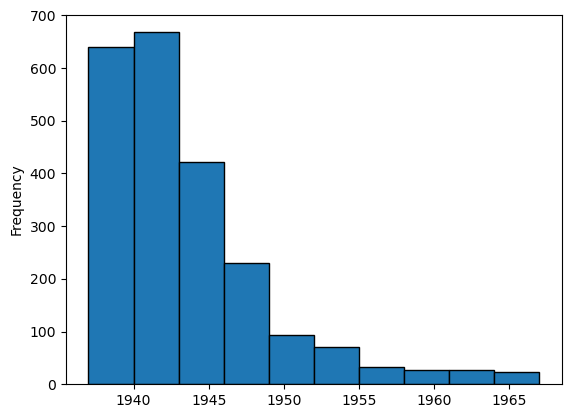

In [6]:
from ProjectFunctions import count_na_in_dataframe

# count number of NA per column
count_na_in_dataframe(undiagnosed_df)

# Plot Brith Year histogram, compare with diagnosed patients
undiagnosed_df["Birth Year"].plot(kind='hist', bins=10, edgecolor='black')

undiagnosed_df.to_csv("undiagnosed.csv", index=False)

# analyze distributions
undiagnosed_df.describe()